<a href="https://colab.research.google.com/github/YuriySamorodov/MIPT/blob/main/student_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ успеваемости студентов

## Подготовка данных и установка библиотек

In [ ]:
# Установка необходимых библиотек
!pip install pandas numpy matplotlib seaborn scikit-learn

In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import gdown

# Настройки отображения
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
%matplotlib inline

# Увеличиваем лимит вывода строк для pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

<ipython-input-3-6aca44b22ed9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Загрузка данных с Google Drive

Сначала нужно подключить Google Drive и загрузить файлы данных. Будем использовать

In [4]:
# Загрузка файлов в Google Colab
train_id = '1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL'
gdown.download(id=train_id,output='train.csv')

lectures_id = '1Op7UOAJwoC9MV4LMTjOBA24jUnTrTmUK'
gdown.download(id=lectures_id,output='lectures.csv')

questions_id = '1x4ybKLXnKUdW-EINwnVG_kJmLzfOTWE1'
gdown.download(id=questions_id,output='questions.csv')

# Загрузка данных
lectures = pd.read_csv('lectures.csv')
questions = pd.read_csv('questions.csv')

# Так как train.csv весит целых 5.45GB, то загрузим и проанализируем первые 1 млн. строк
# Обратим внимание, что все числовые колонки были импортированы с типом Int64, который позволяет хранить числа влоть до девять квинтиллионов (2^63-1), но при этом занимает требует много памяти. Исходя из содержания сэмпла, делаем вывод, что многим полям и не нужен Int64. Уже на этом этапе есть возможность для оптимизации данных.
# Потому на следующем шаге зададим типы данных. Обработка датасета займет больше времени, но размер в памяти будет гораздо меньше.
#

dtypes = {
    'row_id': pd.Int32Dtype,
    'timestamp': pd.Int64Dtype,
    'user_id': pd.Int32Dtype,
    'content_id': pd.Int16Dtype,
    'content_type_id': pd.Int8Dtype,
    'task_container_id': pd.Int16Dtype,
    'user_answer': pd.Int8Dtype,
    'answered_correctly': pd.Int8Dtype,
    'prior_question_elapsed_time': pd.Float32Dtype,
    'prior_question_had_explanation': pd.BooleanDtype
}

train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)

# Проверка загруженных данных
print("Размерности датасетов:")
print(f"train: {train.shape}")
print(f"lectures: {lectures.shape}")
print(f"questions: {questions.shape}")

Downloading...
From (original): https://drive.google.com/uc?id=1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL
From (redirected): https://drive.google.com/uc?id=1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL&confirm=t&uuid=fa486590-b6ef-41ae-a205-67bf0abce589
To: /content/train.csv
100%|██████████| 5.85G/5.85G [00:47<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Op7UOAJwoC9MV4LMTjOBA24jUnTrTmUK
To: /content/lectures.csv
100%|██████████| 9.70k/9.70k [00:00<00:00, 8.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x4ybKLXnKUdW-EINwnVG_kJmLzfOTWE1
To: /content/questions.csv
100%|██████████| 296k/296k [00:00<00:00, 88.4MB/s]
<ipython-input-4-c6ae81cf1a57>:33: UserWarning: Instantiating Int32Dtype without any arguments.Pass a Int32Dtype instance to silence this warning.
  train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)
<ipython-input-4-c6ae81cf1a57>:33: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  train 

Размерности датасетов:
train: (10000000, 10)
lectures: (418, 4)
questions: (13523, 5)


## Функции анализа данных

In [5]:
def analyze_general_statistics(df):
    total_answers = len(df[df['content_type_id'] == 0])
    correct_answers = len(df[(df['content_type_id'] == 0) & (df['answered_correctly'] == 1)])
    accuracy = correct_answers / total_answers * 100

    print(f"Всего ответов: {total_answers:,}")
    print(f"Правильных ответов: {correct_answers:,}")
    print(f"Общая точность: {accuracy:.2f}%")

    # Дополнительная статистика
    print("\nСтатистика по пользователям:")
    print(f"Всего пользователей: {df['user_id'].nunique():,}")
    print(f"Всего вопросов: {df[df['content_type_id'] == 0]['content_id'].nunique():,}")
    print(f"Всего лекций: {df[df['content_type_id'] == 1]['content_id'].nunique():,}")

    return accuracy

In [7]:
def analyze_response_time(df):
    response_times = df[df['prior_question_elapsed_time'].notna()]['prior_question_elapsed_time']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Гистограмма
    sns.histplot(response_times, bins=50, ax=ax1)
    ax1.set_title('Распределение времени ответов')
    ax1.set_xlabel('Время (мс)')
    ax1.set_ylabel('Количество')

    # Box plot
    sns.boxplot(y=response_times, ax=ax2)
    ax2.set_title('Box plot времени ответов')
    ax2.set_ylabel('Время (мс)')

    plt.tight_layout()
    plt.show()

    # Статистика
    print("\nСтатистика времени ответов (мс):")
    print(response_times.describe())

## Анализ данных

In [8]:
# Общая статистика
accuracy = analyze_general_statistics(train)

Всего ответов: 9,804,604
Правильных ответов: 6,457,425
Общая точность: 65.86%

Статистика по пользователям:
Всего пользователей: 39,491
Всего вопросов: 13,500
Всего лекций: 402


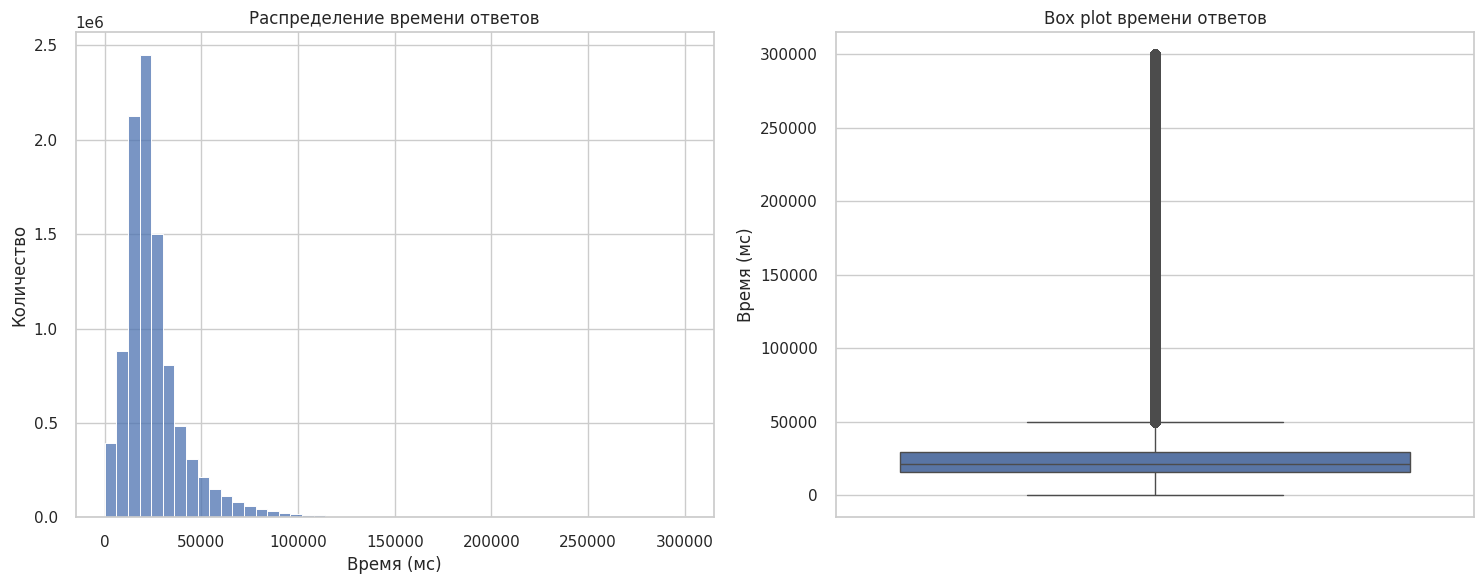


Статистика времени ответов (мс):
count       9765216.0
mean     25475.587891
std      19950.324219
min               0.0
25%           16000.0
50%           21000.0
75%           29666.0
max          300000.0
Name: prior_question_elapsed_time, dtype: Float64


In [9]:
# Анализ времени ответов
analyze_response_time(train)

## Дополнительные исследования

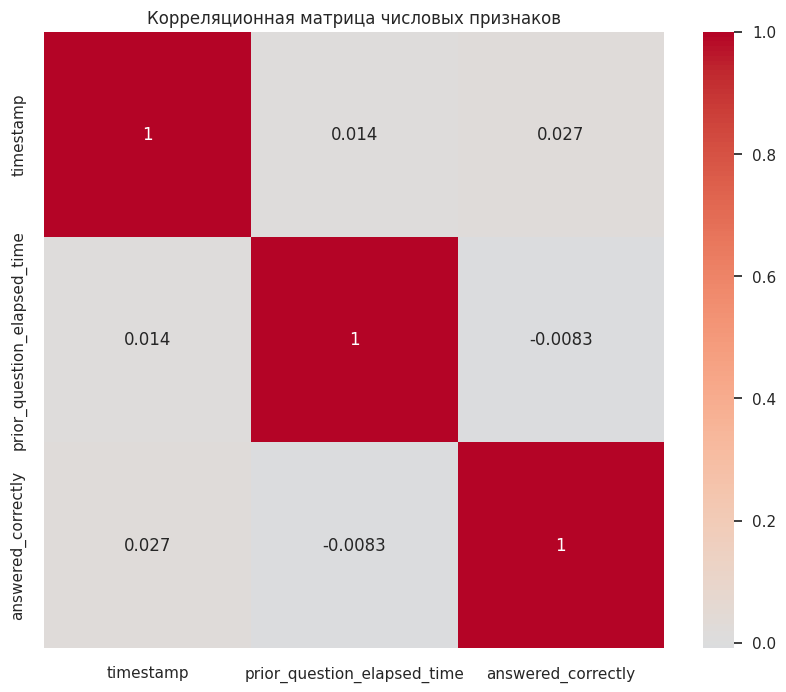

In [10]:
# Корреляционный анализ
numeric_cols = ['timestamp', 'prior_question_elapsed_time', 'answered_correctly']
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [ ]:
# Сохранение результатов анализа
def save_results(df, path):
    results = {
        'total_users': df['user_id'].nunique(),
        'total_questions': df[df['content_type_id'] == 0]['content_id'].nunique(),
        'total_lectures': df[df['content_type_id'] == 1]['content_id'].nunique(),
        'average_accuracy': df[df['content_type_id'] == 0]['answered_correctly'].mean(),
        'average_response_time': df['prior_question_elapsed_time'].mean()
    }

    results_df = pd.DataFrame([results])
    results_df.to_csv(path + 'analysis_results.csv', index=False)
    print("Результаты анализа сохранены в analysis_results.csv")

save_results('train_results.csv')